NOw do all with same seed


In [52]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
Yt=torch.load("/Users/sarahurbut/Dropbox (Personal)/filesforupload/Y_tensor.pt")
E=torch.load("/Users/sarahurbut/Dropbox (Personal)/filesforupload/E_matrix.pt")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/1397768674.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Yt=torch.load("/Users/sarahurbut/Dropbox (Per

In [7]:
import rpy2.robjects as robjects
import numpy as np

# Load the original sparse array from R
r_sparse = robjects.r.readRDS('/Users/sarahurbut/Dropbox (Personal)/withsparse/sparse_array.rds')
matrix = r_sparse[0]  # Get first timepoint

# Try to get rownames using R functions directly
try:
    # Convert to R matrix first
    robjects.r('''
        get_rownames <- function(sparse_matrix) {
            rownames(sparse_matrix)
        }
    ''')
    get_rownames = robjects.globalenv['get_rownames']
    all_patient_ids = np.array(get_rownames(matrix))
    print(f"Successfully extracted {len(all_patient_ids)} patient IDs")
except Exception as e:
    print(f"Error with R method: {e}")
    try:
        # Alternative: try getting directly from matrix slots
        all_patient_ids = np.array(matrix.slots['Dimnames'][0])
        print(f"Got IDs from slots: {len(all_patient_ids)} IDs")
    except Exception as e2:
        print(f"Error with slots method: {e2}")

# Verify we have the IDs
if 'all_patient_ids' in locals():
    print("First few IDs:", all_patient_ids[:5])
    
    def get_batch_ids(start_idx, end_idx):
        return all_patient_ids[start_idx:end_idx]

    # Example: get IDs for first batch
    batch_0_10k_ids = get_batch_ids(0, 10000)
    print(f"First batch IDs: {batch_0_10k_ids[:5]}...")
else:
    print("Failed to get patient IDs")



R[write to console]: Loading required package: Matrix



Successfully extracted 407878 patient IDs
First few IDs: ['1000015' '1000023' '1000037' '1000042' '1000059']
First batch IDs: ['1000015' '1000023' '1000037' '1000042' '1000059']...


In [8]:
import numpy as np

# Convert to numpy array if not already
patient_ids = np.array(all_patient_ids)


In [9]:
import os
import glob
import numpy as np
import torch
import re

# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'

# List all output directories and sort them properly by their index numbers
def sort_by_index(dir_name):
    # Extract just the start number from directory name
    # e.g., from 'output_10000_20000_20241225_062028' get '10000'
    match = re.search(r'output_(\d+)_\d+_\d+', dir_name)
    if match:
        return int(match.group(1))
    return 0

# Test the sorting
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')), key=sort_by_index)

# Print first few directories to verify sorting
print("Verifying directory sorting:")
for dir_path in output_dirs[:5]:
    print(dir_path)


# Initialize the full array
all_lambdas = np.zeros((400000, 20, 52))  # [n_individuals, n_signatures, n_timepoints]

# Keep track of processed indices
processed_ranges = []

# Load and combine lambda from each model
current_idx = 0
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Extract batch range from directory name
        batch_range = re.findall(r'output_(\d+)_(\d+)', os.path.basename(dir_path))
        if batch_range:
            start_idx, end_idx = map(int, batch_range[0])
            print(f"\nProcessing batch {start_idx}-{end_idx}")
            
            # Verify this matches our current_idx
            if current_idx != start_idx:
                print(f"WARNING: Index mismatch! current_idx={current_idx}, but batch starts at {start_idx}")
        
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract lambda
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
        else:
            lambda_values = checkpoint['lambda_']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        
        # Get batch size
        batch_size = lambda_values.shape[0]
        
        # Add to the full array
        all_lambdas[current_idx:current_idx + batch_size] = lambda_values
        
        # Store processed range
        processed_ranges.append((current_idx, current_idx + batch_size))
        
        print(f"Loaded lambda from {dir_path}")
        print(f"Batch size: {batch_size}")
        print(f"Current index range: {current_idx} to {current_idx + batch_size}")
        
        current_idx += batch_size
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Verify no gaps or overlaps in processed ranges
processed_ranges.sort()
for i in range(len(processed_ranges)-1):
    if processed_ranges[i][1] != processed_ranges[i+1][0]:
        print(f"WARNING: Gap or overlap between batches! {processed_ranges[i]} and {processed_ranges[i+1]}")

# Save the combined lambdas
np.save('all_lambdas_combined.npy', all_lambdas)

# Print final verification
print("\nFinal verification:")
print("Shape of all_lambdas:", all_lambdas.shape)
print("Total individuals processed:", current_idx)
print("Processed ranges:", processed_ranges)

# Load patient IDs and verify length matches
patient_ids = np.load('/Users/sarahurbut/Dropbox (Personal)/patient_ids.npy')
# Verify dimensions
print("Total available patient IDs:", len(patient_ids))  # Should be 407,878
print("Processed lambda shape:", all_lambdas.shape)      # Should be (400000, 20, 52)

# Create mapping of processed IDs
processed_ids = patient_ids[:400000]  # Get just the first 400K IDs we processed
print("\nVerification of processed IDs:")
print("Number of processed IDs:", len(processed_ids))
print("First few IDs:", processed_ids[:5])
print("Last few IDs:", processed_ids[-5:])

# Save the processed IDs mapping
np.save('processed_patient_ids.npy', processed_ids)

# Print some stats about unprocessed patients
unprocessed_ids = patient_ids[400000:]
print("\nUnprocessed patients:")
print("Number of unprocessed IDs:", len(unprocessed_ids))
print("First few unprocessed IDs:", unprocessed_ids[:5])

Verifying directory sorting:
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_20000_30000_20241225_093441
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_30000_40000_20241225_093452
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_40000_50000_20241225_124544

Processing batch 0-10000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028
Batch size: 10000
Current index range: 0 to 10000

Processing batch 10000-20000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/1239961796.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028
Batch size: 10000
Current index range: 10000 to 20000

Processing batch 20000-30000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_20000_30000_20241225_093441
Batch size: 10000
Current index range: 20000 to 30000

Processing batch 30000-40000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_30000_40000_20241225_093452
Batch size: 10000
Current index range: 30000 to 40000

Processing batch 40000-50000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_40000_50000_20241225_124544
Batch size: 10000
Current index range: 40000 to 50000

Processing batch 50000-60000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_50000_60000_20241225_124613
Batch size: 10000
Current index range: 50000 to 60000

Processin

In [10]:
def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    x shape: (n_individuals, n_signatures, n_timepoints)
    """
    # Reshape to (n_individuals * n_timepoints, n_signatures)
    x_reshaped = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
    
    # Compute softmax
    e_x = np.exp(x_reshaped - np.max(x_reshaped, axis=1, keepdims=True))
    softmax_x = e_x / np.sum(e_x, axis=1, keepdims=True)
    
    # Reshape back to original shape
    return softmax_x.reshape(x.shape[0], x.shape[2], x.shape[1]).transpose(0, 2, 1)

# Calculate thetas using softmax
all_thetas = softmax(all_lambdas)  # shape: (400000, 20, 52)

# Calculate AUC
timepoints = np.arange(52)
theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(20)]).T


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/2601109579.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(20)]).T


In [11]:
Yt.shape

torch.Size([407878, 348, 52])

In [12]:
Y=Yt

In [15]:
import networkx as nx
from collections import Counter
import matplotlib.pyplot as pltdef 


In [16]:
old=torch.load('/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028/model.pt')
disease_names=old['disease_names']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/684414494.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  old=torch.load('/Users/sarahurbut/Dropbox (Per

In [17]:
disease_names

[np.str_('Bacterial enteritis'),
 np.str_('Viral Enteritis'),
 np.str_('Gram negative septicemia'),
 np.str_('Bacterial infection NOS'),
 np.str_('Staphylococcus infections'),
 np.str_('Streptococcus infection'),
 np.str_('E. coli'),
 np.str_('Viral warts & HPV'),
 np.str_('Viral infection'),
 np.str_('Candidiasis'),
 np.str_('Colon cancer'),
 np.str_('Malignant neoplasm of rectum, rectosigmoid junction, and anus'),
 np.str_('Neoplasm of unspecified nature of digestive system'),
 np.str_('Cancer of bronchus; lung'),
 np.str_('Melanomas of skin'),
 np.str_('Other non-epithelial cancer of skin'),
 np.str_('Breast cancer [female]'),
 np.str_('Malignant neoplasm of female breast'),
 np.str_('Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]'),
 np.str_('Malignant neoplasm of uterus'),
 np.str_('Malignant neoplasm of ovary'),
 np.str_('Cancer of prostate'),
 np.str_('Malignant neoplasm of kidney, except pelvis'),
 np.str_('Malignant neoplasm of bladder'),
 np.str_('Malignant neo

In [ ]:
model.visualize_clusters()

In [19]:
SIGNATURE_CONDITIONS  = {
    'Cardiovascular (5)': [
        'Coronary atherosclerosis',
        'Other chronic ischemic heart disease, unspecified',
        'Myocardial infarction',
        'Hypercholesterolemia',
        'Angina pectoris'
    ],
    
    'Cancer (6)': [
        'Secondary malignancy of bone',
        'Secondary malignant neoplasm of digestive systems',
        'Cancer of bronchus; lung',
        'Secondary malignancy of lymph nodes',
        'Secondary malignant neoplasm'
    ],
    
    'Metabolic (15)': [
        'Type 2 diabetes',
        'Hypoglycemia',
        'Type 2 diabetes with ophthalmic manifestations',
        'Diabetic retinopathy'
    ]
}


In [20]:
def find_transition_patients(lambdas, Y, disease_names):
    """
    Find patients who show clear transitions between signatures
    and have corresponding diseases
    """
    # Convert lambdas to torch tensor if it's not already
    if isinstance(lambdas, np.ndarray):
        lambdas = torch.from_numpy(lambdas).float()
    
  
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y).float()

    
    # Convert signature conditions to numpy strings
    SIGNATURE_CONDITIONS_NP = {
        'Cardiovascular (5)': [np.str_(x) for x in SIGNATURE_CONDITIONS['Cardiovascular (5)']],
        'Cancer (6)': [np.str_(x) for x in SIGNATURE_CONDITIONS['Cancer (6)']],
        'Metabolic (15)': [np.str_(x) for x in SIGNATURE_CONDITIONS['Metabolic (15)']]
    }
    
    # Print conditions we're looking for
    print("\nLooking for conditions:")
    print("CV conditions:", SIGNATURE_CONDITIONS_NP['Cardiovascular (5)'])
    print("Cancer conditions:", SIGNATURE_CONDITIONS_NP['Cancer (6)'])
    print("Metabolic conditions:", SIGNATURE_CONDITIONS_NP['Metabolic (15)'])
    
    # Convert disease_names to list if it's not already
    if not isinstance(disease_names, (list, np.ndarray)):
        disease_names = list(disease_names)
    
    print("\nFirst few disease names:")
    print(disease_names[:10] if len(disease_names) > 10 else disease_names)
    
    interesting_cases = []
    
    # Get indices with debug printing
    cv_indices = []
    cancer_indices = []
    metabolic_indices = []
    
    for i, cond in enumerate(disease_names):
        if any(str(cond) == str(x) for x in SIGNATURE_CONDITIONS_NP['Cardiovascular (5)']):
            cv_indices.append(i)
            print(f"Found CV condition {cond} at index {i}")
        if any(str(cond) == str(x) for x in SIGNATURE_CONDITIONS_NP['Cancer (6)']):
            cancer_indices.append(i)
            print(f"Found Cancer condition {cond} at index {i}")
        if any(str(cond) == str(x) for x in SIGNATURE_CONDITIONS_NP['Metabolic (15)']):
            metabolic_indices.append(i)
            print(f"Found Metabolic condition {cond} at index {i}")
    
    cv_indices = torch.tensor(cv_indices, dtype=torch.long)
    cancer_indices = torch.tensor(cancer_indices, dtype=torch.long)
    metabolic_indices = torch.tensor(metabolic_indices, dtype=torch.long)
    
    # Print the indices we found for debugging
    print("CV indices:", cv_indices)
    print("Cancer indices:", cancer_indices)
    print("Metabolic indices:", metabolic_indices)
    
    count_cv = 0
    count_cancer = 0
    count_metabolic = 0
    count_multiple = 0
    
    softmax = torch.nn.Softmax(dim=0)
    
    for pid in range(len(Y)):
        # Get trajectories and apply softmax
        raw_trajectories = lambdas[pid, [5,6,15], :]  # Shape: [3, 52]
        # Convert to torch tensor if needed
        if not isinstance(raw_trajectories, torch.Tensor):
            raw_trajectories = torch.from_numpy(raw_trajectories).float()
        trajectories = torch.stack([softmax(raw_trajectories[:, t]) for t in range(raw_trajectories.shape[1])], dim=1)
        
        # Check if they have conditions from multiple signatures
        has_cv = torch.any(Y[pid, cv_indices]).item()
        has_cancer = torch.any(Y[pid, cancer_indices]).item()
        has_metabolic = torch.any(Y[pid, metabolic_indices]).item()
        
        # Count conditions for debugging
        if has_cv: count_cv += 1
        if has_cancer: count_cancer += 1
        if has_metabolic: count_metabolic += 1
        if sum([has_cv, has_cancer, has_metabolic]) >= 2:
            count_multiple += 1
        
        if sum([has_cv, has_cancer, has_metabolic]) >= 1:  # At least one condition
            # Check for significant changes in signature strengths
            sig_changes = (trajectories.max(dim=1)[0] - trajectories.min(dim=1)[0])
            if torch.max(sig_changes) > torch.quantile(sig_changes, 0.75):
                interesting_cases.append({
                    'pid': pid,
                    'trajectories': trajectories.detach().cpu().numpy(),
                    'conditions': {
                        'cv': has_cv,
                        'cancer': has_cancer,
                        'metabolic': has_metabolic
                    },
                    'sig_changes': sig_changes.detach().cpu().numpy()
                })
    
    print(f"\nDiagnostic counts:")
    print(f"Patients with CV conditions: {count_cv}")
    print(f"Patients with Cancer conditions: {count_cancer}")
    print(f"Patients with Metabolic conditions: {count_metabolic}")
    print(f"Patients with multiple conditions: {count_multiple}")
    
    return interesting_cases

In [21]:
all_lambdas.shape


(400000, 20, 52)

Starting analysis...
Found 5 CV conditions
Found 6 cancer conditions
Found 4 metabolic conditions
Processed 0 patients...
Processed 1000 patients...
Processed 2000 patients...
Processed 3000 patients...
Processed 4000 patients...
Processed 5000 patients...
Processed 6000 patients...
Processed 7000 patients...
Processed 8000 patients...
Processed 9000 patients...
Processed 10000 patients...
Processed 11000 patients...
Processed 12000 patients...
Processed 13000 patients...
Processed 14000 patients...
Processed 15000 patients...
Processed 16000 patients...
Processed 17000 patients...
Processed 18000 patients...
Processed 19000 patients...
Processed 20000 patients...
Processed 21000 patients...
Processed 22000 patients...
Processed 23000 patients...
Processed 24000 patients...
Processed 25000 patients...
Processed 26000 patients...
Processed 27000 patients...
Processed 28000 patients...
Processed 29000 patients...
Processed 30000 patients...
Processed 31000 patients...
Processed 32000 pat

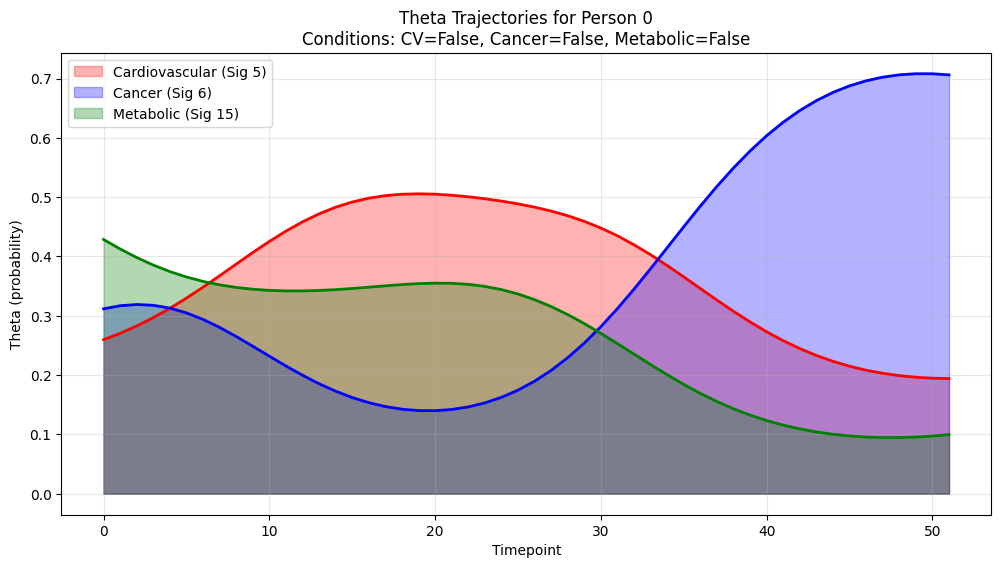

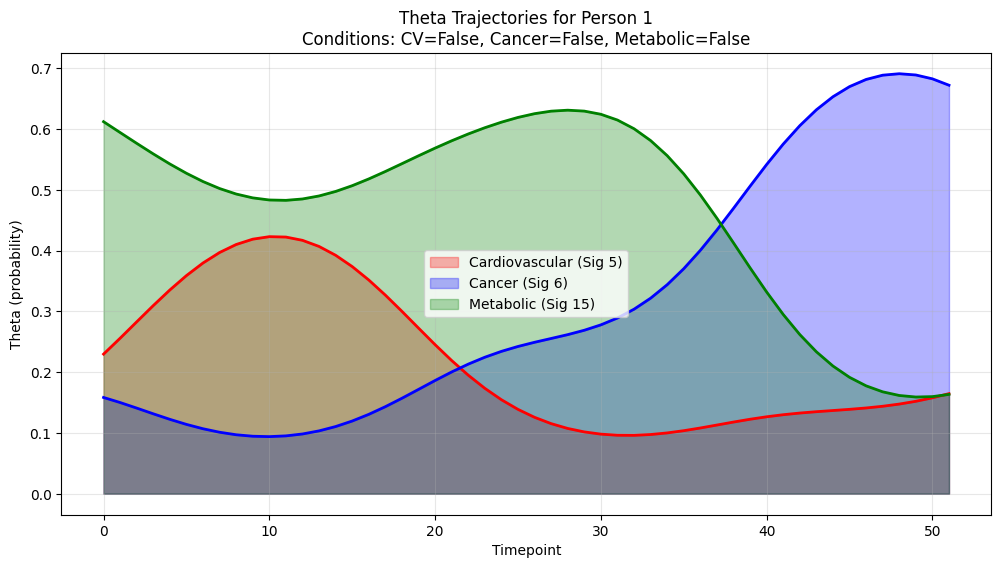

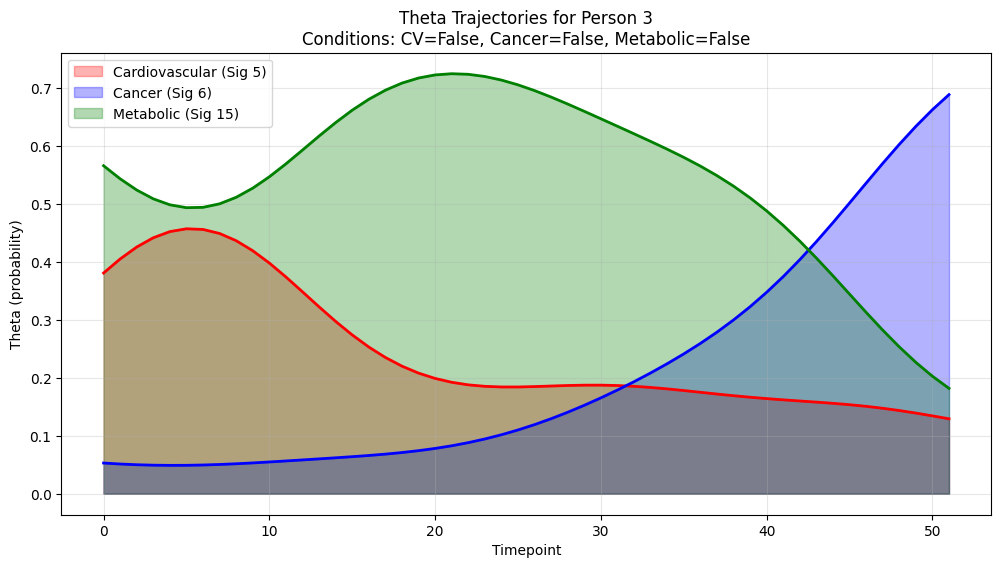

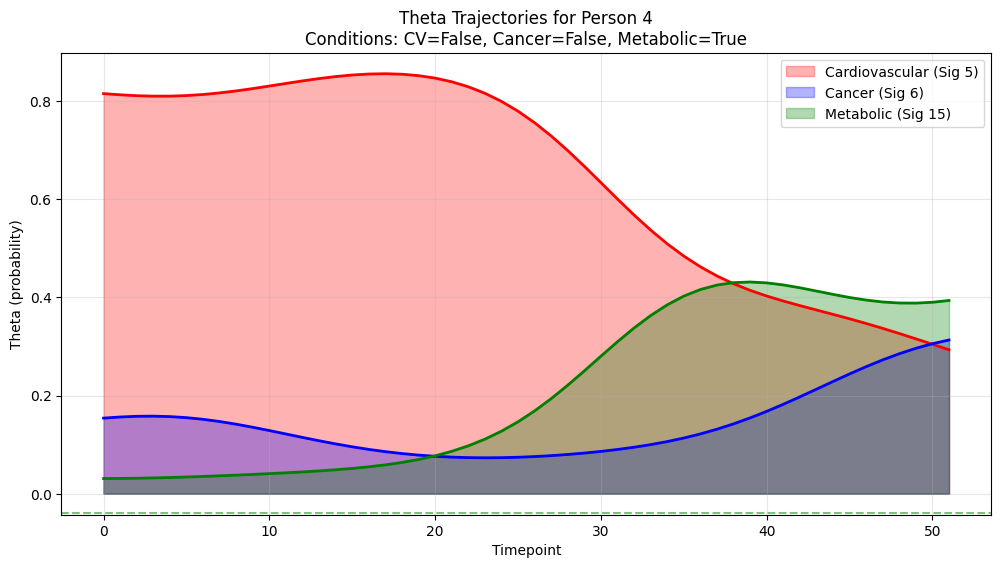

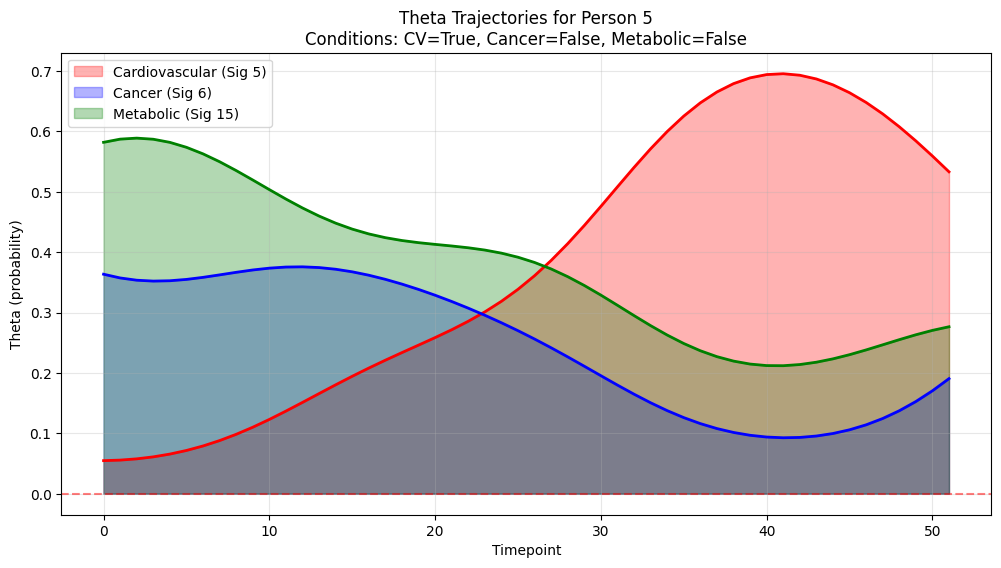

In [24]:

# 1. Make sure we have all necessary imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

def find_transition_patients(lambdas, Y, disease_names):
    """
    Find patients who show clear transitions between signatures
    """
    # Convert lambdas to torch tensor if it's numpy array
    if isinstance(lambdas, np.ndarray):
        lambdas = torch.from_numpy(lambdas).float()
    
    # Convert Y to torch tensor if needed
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y).float()
        
    # Get indices for conditions we care about
    cv_indices = [i for i, name in enumerate(disease_names) 
                 if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Cardiovascular (5)'])]
    cancer_indices = [i for i, name in enumerate(disease_names) 
                     if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Cancer (6)'])]
    metabolic_indices = [i for i, name in enumerate(disease_names) 
                        if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Metabolic (15)'])]
    
    print(f"Found {len(cv_indices)} CV conditions")
    print(f"Found {len(cancer_indices)} cancer conditions")
    print(f"Found {len(metabolic_indices)} metabolic conditions")
    
    interesting_cases = []
    
    for pid in range(len(Y)):
        # Get trajectories for signatures 5, 6, and 15
        trajectories = lambdas[pid, [5,6,15], :].float()  # Shape: [3, 52]
        
        # Apply softmax to get probabilities
        trajectories = torch.stack([softmax(trajectories[:, t], dim=0) 
                                  for t in range(trajectories.shape[1])], dim=1)
        
        # Check if they have any of the conditions
        has_cv = torch.any(Y[pid, cv_indices]).item() if len(cv_indices) > 0 else False
        has_cancer = torch.any(Y[pid, cancer_indices]).item() if len(cancer_indices) > 0 else False
        has_metabolic = torch.any(Y[pid, metabolic_indices]).item() if len(metabolic_indices) > 0 else False
        
        # Look for significant changes in signature strengths
        sig_changes = (trajectories.max(dim=1)[0] - trajectories.min(dim=1)[0])
        
        if torch.max(sig_changes) > 0.3:  # Threshold for interesting change
            interesting_cases.append({
                'pid': pid,
                'trajectories': trajectories.detach().cpu().numpy(),
                'conditions': {
                    'cv': has_cv,
                    'cancer': has_cancer,
                    'metabolic': has_metabolic
                }
            })
            
        if pid % 1000 == 0:
            print(f"Processed {pid} patients...")
    
    return interesting_cases

def plot_theta_trajectories(case):
    """
    Plot signature trajectories for a case
    """
    plt.figure(figsize=(12, 6))
    
    t = np.arange(52)
    trajectories = case['trajectories']
    
    # Plot filled curves
    plt.fill_between(t, 0, trajectories[0], alpha=0.3, color='red', label='Cardiovascular (Sig 5)')
    plt.fill_between(t, 0, trajectories[1], alpha=0.3, color='blue', label='Cancer (Sig 6)')
    plt.fill_between(t, 0, trajectories[2], alpha=0.3, color='green', label='Metabolic (Sig 15)')
    
    # Plot lines
    plt.plot(t, trajectories[0], color='red', linewidth=2)
    plt.plot(t, trajectories[1], color='blue', linewidth=2)
    plt.plot(t, trajectories[2], color='green', linewidth=2)
    
    # Add diagnosis indicators
    y_min = 0
    if case['conditions']['cv']:
        plt.axhline(y=y_min, color='red', linestyle='--', alpha=0.5)
    if case['conditions']['cancer']:
        plt.axhline(y=y_min-0.02, color='blue', linestyle='--', alpha=0.5)
    if case['conditions']['metabolic']:
        plt.axhline(y=y_min-0.04, color='green', linestyle='--', alpha=0.5)
    
    plt.title(f'Theta Trajectories for Person {case["pid"]}\n' + 
             f'Conditions: CV={case["conditions"]["cv"]}, Cancer={case["conditions"]["cancer"]}, ' +
             f'Metabolic={case["conditions"]["metabolic"]}')
    plt.xlabel('Timepoint')
    plt.ylabel('Theta (probability)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

# Run the analysis
print("Starting analysis...")
cases = find_transition_patients(all_lambdas, Yt[:400000,], disease_names)
print(f"\nFound {len(cases)} interesting cases")

# Plot results
if len(cases) > 0:
    print("\nPlotting top 5 cases...")
    for case in cases[:5]:
        plot_theta_trajectories(case)
        plt.show()

In [32]:
def find_transition_patients(lambdas, Y, disease_names):
    """
    Find patients where signature strengths align with disease timing
    """
    if isinstance(lambdas, np.ndarray):
        lambdas = torch.from_numpy(lambdas).float()
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y).float()
    
    # Get indices for conditions
    cv_indices = [i for i, name in enumerate(disease_names) 
                 if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Cardiovascular (5)'])]
    cancer_indices = [i for i, name in enumerate(disease_names) 
                     if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Cancer (6)'])]
    metabolic_indices = [i for i, name in enumerate(disease_names) 
                        if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Metabolic (15)'])]
    
    interesting_cases = []
    n_patients = min(len(Y), len(lambdas))
    
    for pid in range(n_patients):
        trajectories = lambdas[pid, [5,6,15], :]
        trajectories = torch.stack([softmax(trajectories[:, t], dim=0) 
                                  for t in range(trajectories.shape[1])], dim=1)
        
        # Get disease onset times
        cv_onset = torch.where(torch.any(Y[pid, cv_indices, :], dim=0))[0]
        cancer_onset = torch.where(torch.any(Y[pid, cancer_indices, :], dim=0))[0]
        metabolic_onset = torch.where(torch.any(Y[pid, metabolic_indices, :], dim=0))[0]
        
        # Check if signatures are high when diseases occur
        score = 0
        if len(cv_onset) > 0:
            first_cv = cv_onset[0].item()
            cv_strength = trajectories[0, first_cv].item()  # Sig 5 at onset
            score += cv_strength if cv_strength > 0.3 else 0
            
        if len(cancer_onset) > 0:
            first_cancer = cancer_onset[0].item()
            cancer_strength = trajectories[1, first_cancer].item()  # Sig 6 at onset
            score += cancer_strength if cancer_strength > 0.3 else 0
            
        if len(metabolic_onset) > 0:
            first_metabolic = metabolic_onset[0].item()
            metabolic_strength = trajectories[2, first_metabolic].item()  # Sig 15 at onset
            score += metabolic_strength if metabolic_strength > 0.3 else 0
        
        # Only include cases with good alignment
        if score > 0.5:  # Adjust threshold as needed
            interesting_cases.append({
                'pid': pid,
                'trajectories': trajectories.detach().cpu().numpy(),
                'conditions': {
                    'cv': len(cv_onset) > 0,
                    'cancer': len(cancer_onset) > 0,
                    'metabolic': len(metabolic_onset) > 0
                },
                'interest_score': score
            })
            
        if pid % 1000 == 0:
            print(f"Processed {pid} patients...")
    
    # Sort cases by interest score
    interesting_cases.sort(key=lambda x: x['interest_score'], reverse=True)
    
    return interesting_cases, (cv_indices, cancer_indices, metabolic_indices)

In [33]:
# Run the analysis
print("Starting analysis...")
cases, (cv_indices, cancer_indices, metabolic_indices) = find_transition_patients(all_lambdas, Yt[:400000,], disease_names)
print(f"\nFound {len(cases)} interesting cases")


Starting analysis...
Processed 0 patients...
Processed 1000 patients...
Processed 2000 patients...
Processed 3000 patients...
Processed 4000 patients...
Processed 5000 patients...
Processed 6000 patients...
Processed 7000 patients...
Processed 8000 patients...
Processed 9000 patients...
Processed 10000 patients...
Processed 11000 patients...
Processed 12000 patients...
Processed 13000 patients...
Processed 14000 patients...
Processed 15000 patients...
Processed 16000 patients...
Processed 17000 patients...
Processed 18000 patients...
Processed 19000 patients...
Processed 20000 patients...
Processed 21000 patients...
Processed 22000 patients...
Processed 23000 patients...
Processed 24000 patients...
Processed 25000 patients...
Processed 26000 patients...
Processed 27000 patients...
Processed 28000 patients...
Processed 29000 patients...
Processed 30000 patients...
Processed 31000 patients...
Processed 32000 patients...
Processed 33000 patients...
Processed 34000 patients...
Processed 35

In [30]:
def plot_theta_trajectories(case, Y, disease_names, cv_indices, cancer_indices, metabolic_indices):
    """
    Plot signature trajectories with disease timing
    """
    plt.figure(figsize=(12, 6))
    
    # Plot filled areas for each signature
    t = np.arange(52)
    plt.fill_between(t, 0, case['trajectories'][0], alpha=0.3, color='red', label='Cardiovascular (Sig 5)')
    plt.fill_between(t, 0, case['trajectories'][1], alpha=0.3, color='blue', label='Cancer (Sig 6)')
    plt.fill_between(t, 0, case['trajectories'][2], alpha=0.3, color='green', label='Metabolic (Sig 15)')
    
    # Plot lines
    plt.plot(t, case['trajectories'][0], color='red', linewidth=2)
    plt.plot(t, case['trajectories'][1], color='blue', linewidth=2)
    plt.plot(t, case['trajectories'][2], color='green', linewidth=2)
    
    # Add disease timing as vertical lines
    # Get disease occurrences for this patient
    pid = case['pid']
    
    # Check each timepoint for diseases
    for t in range(52):
        if torch.any(Y[pid, cv_indices, t]):
            plt.axvline(x=t, color='red', linestyle='--', alpha=0.5)
        if torch.any(Y[pid, cancer_indices, t]):
            plt.axvline(x=t, color='blue', linestyle='--', alpha=0.5)
        if torch.any(Y[pid, metabolic_indices, t]):
            plt.axvline(x=t, color='green', linestyle='--', alpha=0.5)
    
    plt.title(f"Theta Trajectories for Person {case['pid']}\n" + 
             f"Conditions: CV={case['conditions']['cv']}, Cancer={case['conditions']['cancer']}, " +
             f"Metabolic={case['conditions']['metabolic']}")
    plt.xlabel('Timepoint')
    plt.ylabel('Theta (probability)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt



Plotting top 5 most interesting cases...


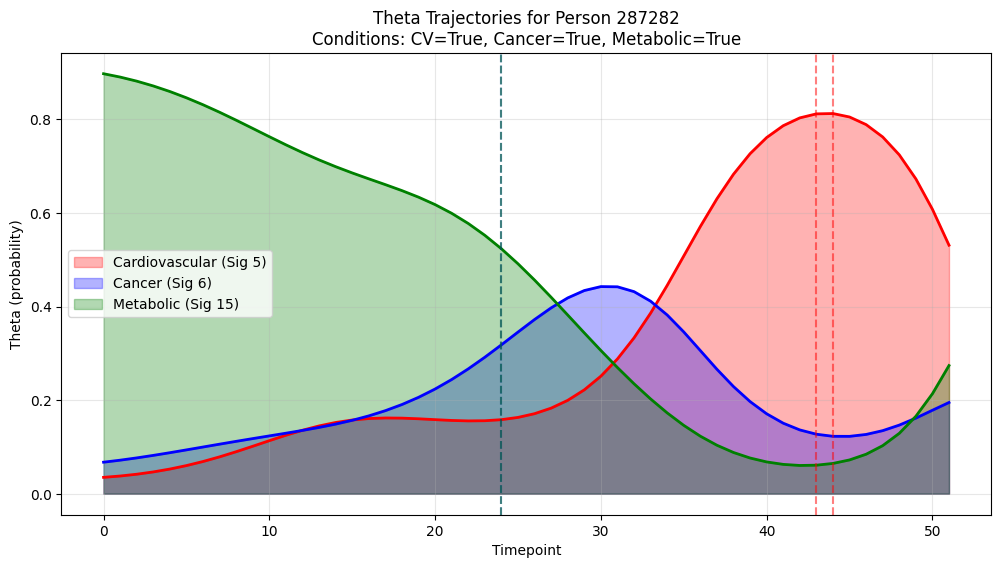

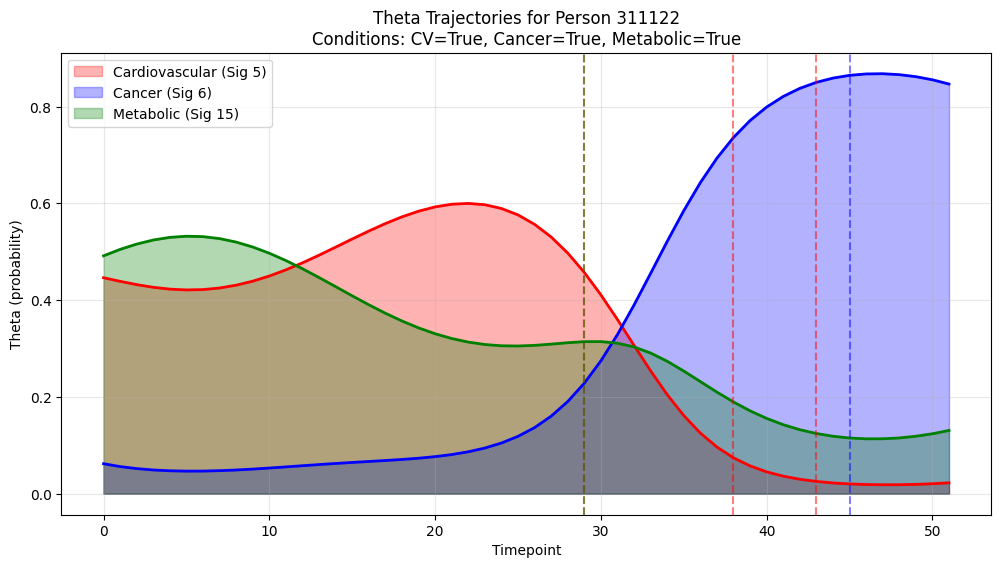

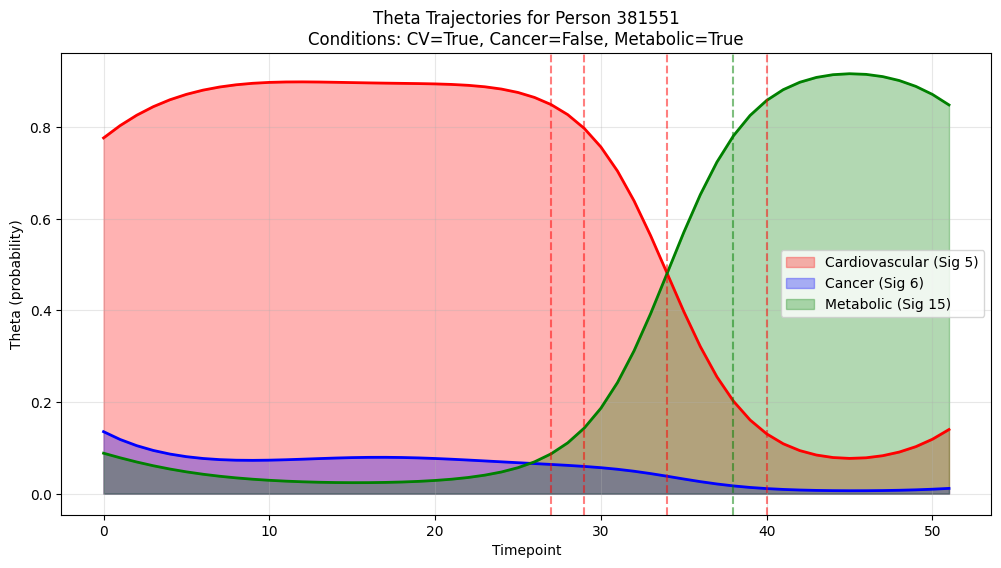

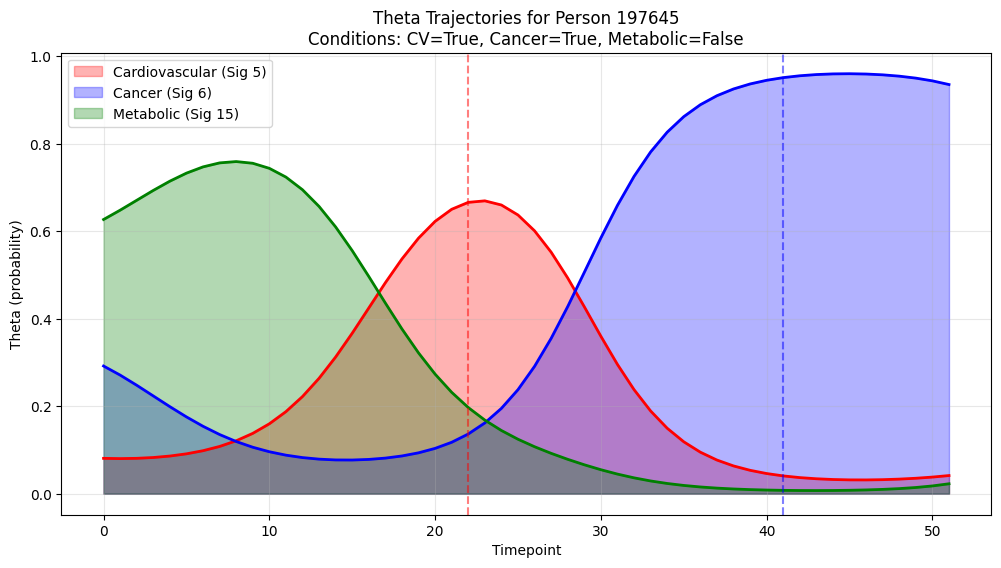

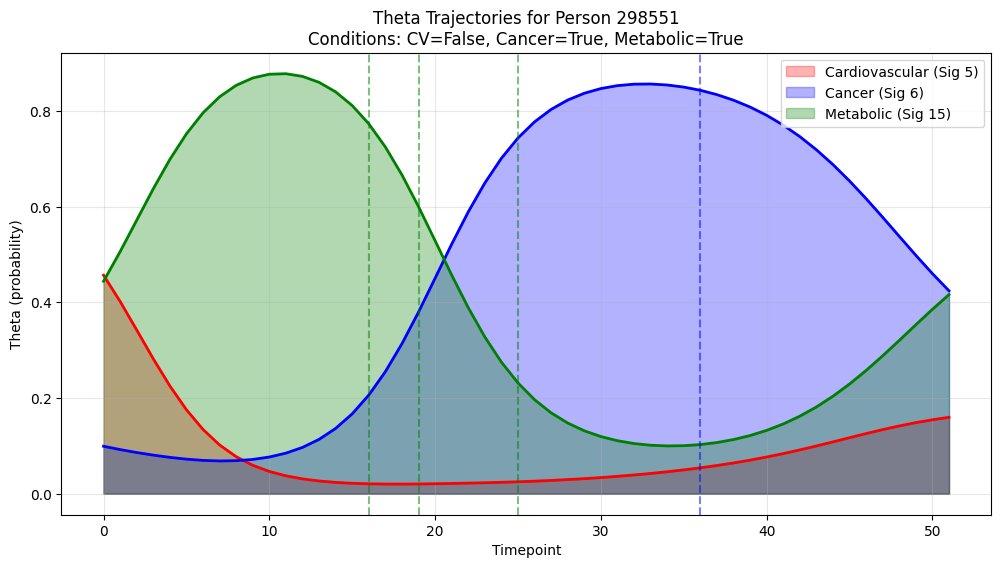

In [34]:

# Plot results
if len(cases) > 0:
    print("\nPlotting top 5 most interesting cases...")
    for case in cases[:5]:
        plot_theta_trajectories(case,  Yt[:400000,], disease_names, cv_indices, cancer_indices, metabolic_indices)
        plt.show()

In [37]:
model=torch.load("/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028/model.pt")
model['clusters']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/4294805997.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load("/Users/sarahurbut/Dropbox (

array([ 3,  3, 16, 16, 16, 16, 16, 19,  3, 16, 17, 17, 17,  6, 19, 19, 19,
       19,  8,  8,  8, 13,  3, 13,  6,  6,  6,  6,  6,  6,  6,  3,  3, 17,
        3,  2,  3,  3,  3, 19,  8,  8,  3, 19, 19,  7, 15, 15, 15, 15, 15,
        7,  5,  3, 16, 16, 16, 16, 16, 16,  7,  2, 16, 16, 16,  3,  7,  7,
        3,  3, 14,  3,  7,  3,  9,  3,  7, 11,  3,  1,  3,  3, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10,  3,  3,  3, 19, 19,  3, 19, 19,  3, 10,
        3,  3,  3,  0,  0,  0,  0,  7, 19,  5,  5,  5,  5,  5,  5,  0,  3,
        0,  0,  0,  3,  3,  0,  0,  0,  0,  3,  3,  0,  0, 11, 11, 11, 11,
       11, 11, 11,  3,  3,  3,  3,  3,  3, 17, 16, 16,  3,  3,  4,  4,  4,
        3,  3,  4,  3,  4, 14, 16, 14,  7, 14, 14, 14, 14, 14, 14,  0, 16,
       14, 16,  3,  3,  3,  3,  3,  3,  3,  2,  7,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  2,  2,  2,  3,  3,  2,  3, 17, 17, 17,  3, 17, 17, 17,
       16,  3,  7, 17, 17, 16, 18, 17, 17,  7,  3, 18, 18, 18, 18, 18, 18,
       18, 18,  3,  3, 17

In [45]:
prevalence=model['prevalence_t']

In [74]:
# First load essentials
def load_model_essentials(base_path='/users/sarahurbut/Dropbox (Personal)/filesforupload/'):
    """Load all essential components"""
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    essentials = torch.load(base_path + 'model_essentials.pt')
    return Y, E, G, essentials

# Load essentials first
Y, E, G, essentials = load_model_essentials()

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/550180415.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/var

In [81]:
def extract_all_pi_theta(model_dir, Y, E, G, essentials):
    """
    Extract all pi and theta values batch by batch
    """
    N = 400000
    batch_size = 10000
    n_batches = N // batch_size
    
    all_pi = np.zeros((N, Y.shape[1], Y.shape[2]), dtype=np.float32)
    all_theta = np.zeros((N, 20, Y.shape[2]), dtype=np.float32)
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        
        batch_dir = f'output_{start_idx}_{end_idx}_*'
        batch_dirs = glob.glob(os.path.join(model_dir, batch_dir))
        
        if not batch_dirs:
            print(f"No directory found for batch {start_idx}-{end_idx}")
            continue
            
        model_path = os.path.join(batch_dirs[0], 'model.pt')
        
        try:
            # Load checkpoint
            checkpoint = torch.load(model_path)
            
            # Initialize model with subset of data
            model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
                N=batch_size,
                D=Y.shape[1],
                T=Y.shape[2],
                K=essentials['K'],
                P=essentials['P'],
                G=G[start_idx:end_idx],
                Y=Y[start_idx:end_idx],
                prevalence_t=essentials['prevalence_t']
            )
            
            # Load state
            model.load_state_dict(checkpoint['model_state_dict'])
            
            # Get pi from forward pass
            with torch.no_grad():
                predicted = model.forward()
                pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
                pi_pred = pi_pred.cpu().numpy().astype(np.float32)
                
                # Get theta from lambda
                lambda_vals = model.lambda_.cpu().numpy()
                theta = special.softmax(lambda_vals, axis=1).astype(np.float32)
            
            # Store
            all_pi[start_idx:end_idx] = pi_pred
            all_theta[start_idx:end_idx] = theta
            
            print(f"Processed batch {start_idx}-{end_idx}")
            
        except Exception as e:
            print(f"Error processing batch {start_idx}-{end_idx}: {e}")
            print(f"Error details: {str(e)}")
    
    return all_pi, all_theta

# Run extraction
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'
all_pi, all_theta = extract_all_pi_theta(
    model_dir=base_dir,
    Y=Y[:400000],
    E=E[:400000],
    G=G[:400000],
    essentials=essentials
)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initialization complete!
Processed batch 0-10000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 25 diseases
Cluster 1: 25 diseases
Cluster 2: 7 diseases
Cluster 3: 23 diseases
Cluster 4: 18 diseases
Cluster 5: 98 diseases
Cluster 6: 8 diseases
Cluster 7: 9 diseases
Cluster 8: 9 diseases
Cluster 9: 5 diseases
Cluster 10: 11 diseases
Cluster 11: 16 diseases
Cluster 12: 9 diseases
Cluster 13: 11 diseases
Cluster 14: 5 diseases
Cluster 15: 12 diseases
Cluster 16: 25 diseases
Cluster 17: 7 diseases
Cluster 18: 16 diseases
Cluster 19: 9 diseases
Initialization complete!
Processed batch 10000-20000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 9 diseases
Cluster 2: 9 diseases
Cluster 3: 13 diseases
Cluster 4: 19 diseases
Cluster 5: 14 diseases
Cluster 6: 17 diseases
Cluster 7: 18 diseases
Cluster 8: 17 diseases
Cluster 9: 87 diseases
Cluster 10: 13 diseases
Cluster 11: 8 diseases
Cluster 12: 5 diseases
Cluster 13: 31 diseases
Cluster 14: 28 diseases
Cluster 15: 22 diseases
Cluster 16: 5 diseases
Cluster 17: 7 diseases
Cluster 18: 7 diseases
Cluster 19: 8 diseases
Initialization complete!
Processed batch 20000-30000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 28 diseases
Cluster 1: 11 diseases
Cluster 2: 13 diseases
Cluster 3: 11 diseases
Cluster 4: 18 diseases
Cluster 5: 6 diseases
Cluster 6: 9 diseases
Cluster 7: 8 diseases
Cluster 8: 16 diseases
Cluster 9: 9 diseases
Cluster 10: 6 diseases
Cluster 11: 26 diseases
Cluster 12: 14 diseases
Cluster 13: 18 diseases
Cluster 14: 22 diseases
Cluster 15: 12 diseases
Cluster 16: 31 diseases
Cluster 17: 4 diseases
Cluster 18: 17 diseases
Cluster 19: 69 diseases
Initialization complete!
Processed batch 30000-40000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 12 diseases
Cluster 1: 15 diseases
Cluster 2: 16 diseases
Cluster 3: 52 diseases
Cluster 4: 5 diseases
Cluster 5: 15 diseases
Cluster 6: 13 diseases
Cluster 7: 12 diseases
Cluster 8: 76 diseases
Cluster 9: 5 diseases
Cluster 10: 9 diseases
Cluster 11: 5 diseases
Cluster 12: 7 diseases
Cluster 13: 25 diseases
Cluster 14: 6 diseases
Cluster 15: 11 diseases
Cluster 16: 7 diseases
Cluster 17: 13 diseases
Cluster 18: 12 diseases
Cluster 19: 32 diseases
Initialization complete!
Processed batch 40000-50000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 22 diseases
Cluster 1: 24 diseases
Cluster 2: 16 diseases
Cluster 3: 5 diseases
Cluster 4: 8 diseases
Cluster 5: 9 diseases
Cluster 6: 31 diseases
Cluster 7: 16 diseases
Cluster 8: 9 diseases
Cluster 9: 8 diseases
Cluster 10: 13 diseases
Cluster 11: 17 diseases
Cluster 12: 14 diseases
Cluster 13: 8 diseases
Cluster 14: 5 diseases
Cluster 15: 12 diseases
Cluster 16: 12 diseases
Cluster 17: 88 diseases
Cluster 18: 9 diseases
Cluster 19: 22 diseases
Initialization complete!
Processed batch 50000-60000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 14 diseases
Cluster 2: 28 diseases
Cluster 3: 80 diseases
Cluster 4: 9 diseases
Cluster 5: 14 diseases
Cluster 6: 13 diseases
Cluster 7: 12 diseases
Cluster 8: 17 diseases
Cluster 9: 14 diseases
Cluster 10: 7 diseases
Cluster 11: 22 diseases
Cluster 12: 9 diseases
Cluster 13: 5 diseases
Cluster 14: 35 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 7 diseases
Cluster 18: 7 diseases
Cluster 19: 8 diseases
Initialization complete!
Processed batch 60000-70000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 14 diseases
Cluster 2: 17 diseases
Cluster 3: 8 diseases
Cluster 4: 16 diseases
Cluster 5: 114 diseases
Cluster 6: 13 diseases
Cluster 7: 10 diseases
Cluster 8: 16 diseases
Cluster 9: 9 diseases
Cluster 10: 6 diseases
Cluster 11: 10 diseases
Cluster 12: 9 diseases
Cluster 13: 11 diseases
Cluster 14: 5 diseases
Cluster 15: 9 diseases
Cluster 16: 16 diseases
Cluster 17: 24 diseases
Cluster 18: 12 diseases
Cluster 19: 18 diseases
Initialization complete!
Processed batch 70000-80000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 17 diseases
Cluster 1: 24 diseases
Cluster 2: 5 diseases
Cluster 3: 10 diseases
Cluster 4: 16 diseases
Cluster 5: 13 diseases
Cluster 6: 12 diseases
Cluster 7: 20 diseases
Cluster 8: 32 diseases
Cluster 9: 9 diseases
Cluster 10: 100 diseases
Cluster 11: 13 diseases
Cluster 12: 9 diseases
Cluster 13: 8 diseases
Cluster 14: 17 diseases
Cluster 15: 5 diseases
Cluster 16: 4 diseases
Cluster 17: 14 diseases
Cluster 18: 11 diseases
Cluster 19: 9 diseases
Initialization complete!
Processed batch 80000-90000
Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s


Cluster Sizes:
Cluster 0: 7 diseases
Cluster 1: 20 diseases
Cluster 2: 8 diseases
Cluster 3: 19 diseases
Cluster 4: 7 diseases
Cluster 5: 22 diseases
Cluster 6: 12 diseases
Cluster 7: 15 diseases
Cluster 8: 9 diseases
Cluster 9: 5 diseases
Cluster 10: 9 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 15 diseases
Cluster 14: 5 diseases
Cluster 15: 13 diseases
Cluster 16: 8 diseases
Cluster 17: 22 diseases
Cluster 18: 20 diseases
Cluster 19: 94 diseases
Initialization complete!
Processed batch 90000-100000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 42 diseases
Cluster 1: 24 diseases
Cluster 2: 8 diseases
Cluster 3: 5 diseases
Cluster 4: 8 diseases
Cluster 5: 13 diseases
Cluster 6: 60 diseases
Cluster 7: 30 diseases
Cluster 8: 7 diseases
Cluster 9: 19 diseases
Cluster 10: 10 diseases
Cluster 11: 15 diseases
Cluster 12: 16 diseases
Cluster 13: 11 diseases
Cluster 14: 7 diseases
Cluster 15: 7 diseases
Cluster 16: 12 diseases
Cluster 17: 16 diseases
Cluster 18: 22 diseases
Cluster 19: 16 diseases
Initialization complete!
Processed batch 100000-110000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 27 diseases
Cluster 2: 9 diseases
Cluster 3: 22 diseases
Cluster 4: 13 diseases
Cluster 5: 4 diseases
Cluster 6: 13 diseases
Cluster 7: 8 diseases
Cluster 8: 15 diseases
Cluster 9: 13 diseases
Cluster 10: 27 diseases
Cluster 11: 6 diseases
Cluster 12: 12 diseases
Cluster 13: 16 diseases
Cluster 14: 9 diseases
Cluster 15: 28 diseases
Cluster 16: 8 diseases
Cluster 17: 15 diseases
Cluster 18: 87 diseases
Cluster 19: 5 diseases
Initialization complete!
Processed batch 110000-120000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 6 diseases
Cluster 2: 5 diseases
Cluster 3: 18 diseases
Cluster 4: 8 diseases
Cluster 5: 6 diseases
Cluster 6: 26 diseases
Cluster 7: 97 diseases
Cluster 8: 27 diseases
Cluster 9: 12 diseases
Cluster 10: 14 diseases
Cluster 11: 15 diseases
Cluster 12: 14 diseases
Cluster 13: 6 diseases
Cluster 14: 5 diseases
Cluster 15: 18 diseases
Cluster 16: 7 diseases
Cluster 17: 9 diseases
Cluster 18: 15 diseases
Cluster 19: 29 diseases
Initialization complete!
Processed batch 120000-130000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 21 diseases
Cluster 2: 16 diseases
Cluster 3: 13 diseases
Cluster 4: 13 diseases
Cluster 5: 6 diseases
Cluster 6: 9 diseases
Cluster 7: 87 diseases
Cluster 8: 8 diseases
Cluster 9: 11 diseases
Cluster 10: 12 diseases
Cluster 11: 25 diseases
Cluster 12: 11 diseases
Cluster 13: 5 diseases
Cluster 14: 8 diseases
Cluster 15: 31 diseases
Cluster 16: 18 diseases
Cluster 17: 27 diseases
Cluster 18: 7 diseases
Cluster 19: 7 diseases
Initialization complete!
Processed batch 130000-140000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 18 diseases
Cluster 1: 11 diseases
Cluster 2: 20 diseases
Cluster 3: 8 diseases
Cluster 4: 8 diseases
Cluster 5: 5 diseases
Cluster 6: 26 diseases
Cluster 7: 19 diseases
Cluster 8: 5 diseases
Cluster 9: 28 diseases
Cluster 10: 11 diseases
Cluster 11: 9 diseases
Cluster 12: 16 diseases
Cluster 13: 14 diseases
Cluster 14: 14 diseases
Cluster 15: 15 diseases
Cluster 16: 8 diseases
Cluster 17: 95 diseases
Cluster 18: 11 diseases
Cluster 19: 7 diseases
Initialization complete!
Processed batch 140000-150000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 15 diseases
Cluster 1: 18 diseases
Cluster 2: 82 diseases
Cluster 3: 29 diseases
Cluster 4: 9 diseases
Cluster 5: 7 diseases
Cluster 6: 24 diseases
Cluster 7: 11 diseases
Cluster 8: 12 diseases
Cluster 9: 8 diseases
Cluster 10: 31 diseases
Cluster 11: 5 diseases
Cluster 12: 15 diseases
Cluster 13: 21 diseases
Cluster 14: 8 diseases
Cluster 15: 5 diseases
Cluster 16: 10 diseases
Cluster 17: 15 diseases
Cluster 18: 17 diseases
Cluster 19: 6 diseases
Initialization complete!
Processed batch 150000-160000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 13 diseases
Cluster 2: 6 diseases
Cluster 3: 17 diseases
Cluster 4: 9 diseases
Cluster 5: 24 diseases
Cluster 6: 11 diseases
Cluster 7: 84 diseases
Cluster 8: 6 diseases
Cluster 9: 12 diseases
Cluster 10: 7 diseases
Cluster 11: 14 diseases
Cluster 12: 11 diseases
Cluster 13: 10 diseases
Cluster 14: 39 diseases
Cluster 15: 30 diseases
Cluster 16: 8 diseases
Cluster 17: 4 diseases
Cluster 18: 19 diseases
Cluster 19: 8 diseases
Initialization complete!
Processed batch 160000-170000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 27 diseases
Cluster 2: 18 diseases
Cluster 3: 9 diseases
Cluster 4: 29 diseases
Cluster 5: 6 diseases
Cluster 6: 31 diseases
Cluster 7: 5 diseases
Cluster 8: 30 diseases
Cluster 9: 8 diseases
Cluster 10: 12 diseases
Cluster 11: 15 diseases
Cluster 12: 5 diseases
Cluster 13: 11 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 6 diseases
Cluster 17: 15 diseases
Cluster 18: 11 diseases
Cluster 19: 82 diseases
Initialization complete!
Processed batch 170000-180000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 89 diseases
Cluster 1: 6 diseases
Cluster 2: 10 diseases
Cluster 3: 15 diseases
Cluster 4: 8 diseases
Cluster 5: 28 diseases
Cluster 6: 8 diseases
Cluster 7: 10 diseases
Cluster 8: 21 diseases
Cluster 9: 5 diseases
Cluster 10: 37 diseases
Cluster 11: 9 diseases
Cluster 12: 13 diseases
Cluster 13: 15 diseases
Cluster 14: 13 diseases
Cluster 15: 17 diseases
Cluster 16: 8 diseases
Cluster 17: 13 diseases
Cluster 18: 10 diseases
Cluster 19: 13 diseases
Initialization complete!
Processed batch 180000-190000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 10 diseases
Cluster 1: 9 diseases
Cluster 2: 26 diseases
Cluster 3: 19 diseases
Cluster 4: 27 diseases
Cluster 5: 96 diseases
Cluster 6: 14 diseases
Cluster 7: 5 diseases
Cluster 8: 15 diseases
Cluster 9: 9 diseases
Cluster 10: 16 diseases
Cluster 11: 13 diseases
Cluster 12: 17 diseases
Cluster 13: 10 diseases
Cluster 14: 7 diseases
Cluster 15: 13 diseases
Cluster 16: 9 diseases
Cluster 17: 19 diseases
Cluster 18: 9 diseases
Cluster 19: 5 diseases
Initialization complete!
Processed batch 190000-200000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 28 diseases
Cluster 2: 9 diseases
Cluster 3: 24 diseases
Cluster 4: 16 diseases
Cluster 5: 9 diseases
Cluster 6: 19 diseases
Cluster 7: 16 diseases
Cluster 8: 78 diseases
Cluster 9: 12 diseases
Cluster 10: 22 diseases
Cluster 11: 18 diseases
Cluster 12: 5 diseases
Cluster 13: 5 diseases
Cluster 14: 13 diseases
Cluster 15: 22 diseases
Cluster 16: 11 diseases
Cluster 17: 8 diseases
Cluster 18: 15 diseases
Cluster 19: 7 diseases
Initialization complete!
Processed batch 200000-210000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 7 diseases
Cluster 2: 14 diseases
Cluster 3: 102 diseases
Cluster 4: 9 diseases
Cluster 5: 18 diseases
Cluster 6: 5 diseases
Cluster 7: 26 diseases
Cluster 8: 9 diseases
Cluster 9: 8 diseases
Cluster 10: 12 diseases
Cluster 11: 14 diseases
Cluster 12: 14 diseases
Cluster 13: 10 diseases
Cluster 14: 5 diseases
Cluster 15: 12 diseases
Cluster 16: 25 diseases
Cluster 17: 5 diseases
Cluster 18: 24 diseases
Cluster 19: 13 diseases
Initialization complete!
Processed batch 210000-220000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 12 diseases
Cluster 2: 17 diseases
Cluster 3: 27 diseases
Cluster 4: 39 diseases
Cluster 5: 9 diseases
Cluster 6: 9 diseases
Cluster 7: 8 diseases
Cluster 8: 5 diseases
Cluster 9: 80 diseases
Cluster 10: 10 diseases
Cluster 11: 12 diseases
Cluster 12: 16 diseases
Cluster 13: 12 diseases
Cluster 14: 8 diseases
Cluster 15: 5 diseases
Cluster 16: 22 diseases
Cluster 17: 10 diseases
Cluster 18: 15 diseases
Cluster 19: 16 diseases
Initialization complete!
Processed batch 220000-230000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 17 diseases
Cluster 1: 14 diseases
Cluster 2: 5 diseases
Cluster 3: 37 diseases
Cluster 4: 20 diseases
Cluster 5: 10 diseases
Cluster 6: 86 diseases
Cluster 7: 24 diseases
Cluster 8: 6 diseases
Cluster 9: 13 diseases
Cluster 10: 8 diseases
Cluster 11: 17 diseases
Cluster 12: 5 diseases
Cluster 13: 11 diseases
Cluster 14: 8 diseases
Cluster 15: 10 diseases
Cluster 16: 4 diseases
Cluster 17: 8 diseases
Cluster 18: 10 diseases
Cluster 19: 35 diseases
Initialization complete!
Processed batch 230000-240000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 28 diseases
Cluster 1: 29 diseases
Cluster 2: 14 diseases
Cluster 3: 8 diseases
Cluster 4: 102 diseases
Cluster 5: 13 diseases
Cluster 6: 9 diseases
Cluster 7: 16 diseases
Cluster 8: 19 diseases
Cluster 9: 7 diseases
Cluster 10: 16 diseases
Cluster 11: 13 diseases
Cluster 12: 6 diseases
Cluster 13: 6 diseases
Cluster 14: 5 diseases
Cluster 15: 13 diseases
Cluster 16: 15 diseases
Cluster 17: 6 diseases
Cluster 18: 12 diseases
Cluster 19: 11 diseases
Initialization complete!
Processed batch 240000-250000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 88 diseases
Cluster 1: 17 diseases
Cluster 2: 13 diseases
Cluster 3: 17 diseases
Cluster 4: 17 diseases
Cluster 5: 9 diseases
Cluster 6: 10 diseases
Cluster 7: 21 diseases
Cluster 8: 23 diseases
Cluster 9: 4 diseases
Cluster 10: 8 diseases
Cluster 11: 9 diseases
Cluster 12: 4 diseases
Cluster 13: 22 diseases
Cluster 14: 21 diseases
Cluster 15: 11 diseases
Cluster 16: 26 diseases
Cluster 17: 6 diseases
Cluster 18: 8 diseases
Cluster 19: 14 diseases
Initialization complete!
Processed batch 250000-260000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 28 diseases
Cluster 1: 16 diseases
Cluster 2: 17 diseases
Cluster 3: 14 diseases
Cluster 4: 6 diseases
Cluster 5: 23 diseases
Cluster 6: 28 diseases
Cluster 7: 8 diseases
Cluster 8: 10 diseases
Cluster 9: 9 diseases
Cluster 10: 10 diseases
Cluster 11: 65 diseases
Cluster 12: 14 diseases
Cluster 13: 13 diseases
Cluster 14: 2 diseases
Cluster 15: 6 diseases
Cluster 16: 20 diseases
Cluster 17: 5 diseases
Cluster 18: 47 diseases
Cluster 19: 7 diseases
Initialization complete!
Processed batch 260000-270000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 15 diseases
Cluster 1: 95 diseases
Cluster 2: 6 diseases
Cluster 3: 25 diseases
Cluster 4: 8 diseases
Cluster 5: 14 diseases
Cluster 6: 7 diseases
Cluster 7: 22 diseases
Cluster 8: 24 diseases
Cluster 9: 8 diseases
Cluster 10: 13 diseases
Cluster 11: 12 diseases
Cluster 12: 9 diseases
Cluster 13: 15 diseases
Cluster 14: 13 diseases
Cluster 15: 18 diseases
Cluster 16: 20 diseases
Cluster 17: 5 diseases
Cluster 18: 9 diseases
Cluster 19: 10 diseases
Initialization complete!
Processed batch 270000-280000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 15 diseases
Cluster 2: 11 diseases
Cluster 3: 102 diseases
Cluster 4: 17 diseases
Cluster 5: 26 diseases
Cluster 6: 9 diseases
Cluster 7: 14 diseases
Cluster 8: 7 diseases
Cluster 9: 10 diseases
Cluster 10: 28 diseases
Cluster 11: 5 diseases
Cluster 12: 16 diseases
Cluster 13: 24 diseases
Cluster 14: 8 diseases
Cluster 15: 5 diseases
Cluster 16: 10 diseases
Cluster 17: 12 diseases
Cluster 18: 9 diseases
Cluster 19: 7 diseases
Initialization complete!
Processed batch 280000-290000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 11 diseases
Cluster 2: 7 diseases
Cluster 3: 13 diseases
Cluster 4: 16 diseases
Cluster 5: 8 diseases
Cluster 6: 5 diseases
Cluster 7: 31 diseases
Cluster 8: 28 diseases
Cluster 9: 9 diseases
Cluster 10: 13 diseases
Cluster 11: 9 diseases
Cluster 12: 8 diseases
Cluster 13: 5 diseases
Cluster 14: 18 diseases
Cluster 15: 80 diseases
Cluster 16: 16 diseases
Cluster 17: 9 diseases
Cluster 18: 14 diseases
Cluster 19: 32 diseases
Initialization complete!
Processed batch 290000-300000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 27 diseases
Cluster 2: 12 diseases
Cluster 3: 11 diseases
Cluster 4: 27 diseases
Cluster 5: 8 diseases
Cluster 6: 4 diseases
Cluster 7: 13 diseases
Cluster 8: 8 diseases
Cluster 9: 8 diseases
Cluster 10: 7 diseases
Cluster 11: 7 diseases
Cluster 12: 32 diseases
Cluster 13: 12 diseases
Cluster 14: 20 diseases
Cluster 15: 22 diseases
Cluster 16: 10 diseases
Cluster 17: 15 diseases
Cluster 18: 85 diseases
Cluster 19: 6 diseases
Initialization complete!
Processed batch 300000-310000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 26 diseases
Cluster 1: 24 diseases
Cluster 2: 21 diseases
Cluster 3: 7 diseases
Cluster 4: 8 diseases
Cluster 5: 5 diseases
Cluster 6: 86 diseases
Cluster 7: 9 diseases
Cluster 8: 8 diseases
Cluster 9: 7 diseases
Cluster 10: 25 diseases
Cluster 11: 21 diseases
Cluster 12: 13 diseases
Cluster 13: 10 diseases
Cluster 14: 5 diseases
Cluster 15: 13 diseases
Cluster 16: 11 diseases
Cluster 17: 8 diseases
Cluster 18: 29 diseases
Cluster 19: 12 diseases
Initialization complete!
Processed batch 310000-320000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 14 diseases
Cluster 2: 26 diseases
Cluster 3: 16 diseases
Cluster 4: 5 diseases
Cluster 5: 21 diseases
Cluster 6: 8 diseases
Cluster 7: 7 diseases
Cluster 8: 8 diseases
Cluster 9: 10 diseases
Cluster 10: 26 diseases
Cluster 11: 104 diseases
Cluster 12: 13 diseases
Cluster 13: 6 diseases
Cluster 14: 5 diseases
Cluster 15: 16 diseases
Cluster 16: 11 diseases
Cluster 17: 15 diseases
Cluster 18: 13 diseases
Cluster 19: 10 diseases
Initialization complete!
Processed batch 320000-330000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 12 diseases
Cluster 2: 7 diseases
Cluster 3: 11 diseases
Cluster 4: 9 diseases
Cluster 5: 14 diseases
Cluster 6: 98 diseases
Cluster 7: 14 diseases
Cluster 8: 13 diseases
Cluster 9: 27 diseases
Cluster 10: 17 diseases
Cluster 11: 17 diseases
Cluster 12: 5 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 24 diseases
Cluster 16: 22 diseases
Cluster 17: 5 diseases
Cluster 18: 12 diseases
Cluster 19: 14 diseases
Initialization complete!
Processed batch 330000-340000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 10 diseases
Cluster 1: 15 diseases
Cluster 2: 11 diseases
Cluster 3: 18 diseases
Cluster 4: 9 diseases
Cluster 5: 5 diseases
Cluster 6: 5 diseases
Cluster 7: 17 diseases
Cluster 8: 7 diseases
Cluster 9: 8 diseases
Cluster 10: 28 diseases
Cluster 11: 30 diseases
Cluster 12: 12 diseases
Cluster 13: 99 diseases
Cluster 14: 24 diseases
Cluster 15: 18 diseases
Cluster 16: 9 diseases
Cluster 17: 13 diseases
Cluster 18: 4 diseases
Cluster 19: 6 diseases
Initialization complete!
Processed batch 340000-350000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 26 diseases
Cluster 2: 10 diseases
Cluster 3: 14 diseases
Cluster 4: 5 diseases
Cluster 5: 6 diseases
Cluster 6: 8 diseases
Cluster 7: 76 diseases
Cluster 8: 26 diseases
Cluster 9: 16 diseases
Cluster 10: 9 diseases
Cluster 11: 8 diseases
Cluster 12: 12 diseases
Cluster 13: 13 diseases
Cluster 14: 51 diseases
Cluster 15: 9 diseases
Cluster 16: 16 diseases
Cluster 17: 6 diseases
Cluster 18: 13 diseases
Cluster 19: 11 diseases
Initialization complete!
Processed batch 350000-360000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 30 diseases
Cluster 1: 14 diseases
Cluster 2: 15 diseases
Cluster 3: 13 diseases
Cluster 4: 8 diseases
Cluster 5: 5 diseases
Cluster 6: 9 diseases
Cluster 7: 11 diseases
Cluster 8: 30 diseases
Cluster 9: 86 diseases
Cluster 10: 8 diseases
Cluster 11: 21 diseases
Cluster 12: 11 diseases
Cluster 13: 15 diseases
Cluster 14: 25 diseases
Cluster 15: 12 diseases
Cluster 16: 5 diseases
Cluster 17: 5 diseases
Cluster 18: 16 diseases
Cluster 19: 9 diseases
Initialization complete!
Processed batch 360000-370000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 19 diseases
Cluster 1: 13 diseases
Cluster 2: 6 diseases
Cluster 3: 22 diseases
Cluster 4: 15 diseases
Cluster 5: 9 diseases
Cluster 6: 13 diseases
Cluster 7: 5 diseases
Cluster 8: 5 diseases
Cluster 9: 19 diseases
Cluster 10: 7 diseases
Cluster 11: 25 diseases
Cluster 12: 19 diseases
Cluster 13: 15 diseases
Cluster 14: 14 diseases
Cluster 15: 10 diseases
Cluster 16: 10 diseases
Cluster 17: 5 diseases
Cluster 18: 14 diseases
Cluster 19: 103 diseases
Initialization complete!
Processed batch 370000-380000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 15 diseases
Cluster 1: 23 diseases
Cluster 2: 10 diseases
Cluster 3: 6 diseases
Cluster 4: 14 diseases
Cluster 5: 12 diseases
Cluster 6: 5 diseases
Cluster 7: 10 diseases
Cluster 8: 12 diseases
Cluster 9: 8 diseases
Cluster 10: 41 diseases
Cluster 11: 11 diseases
Cluster 12: 9 diseases
Cluster 13: 25 diseases
Cluster 14: 8 diseases
Cluster 15: 14 diseases
Cluster 16: 25 diseases
Cluster 17: 80 diseases
Cluster 18: 11 diseases
Cluster 19: 9 diseases
Initialization complete!
Processed batch 380000-390000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/3085464216.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 12 diseases
Cluster 1: 18 diseases
Cluster 2: 40 diseases
Cluster 3: 15 diseases
Cluster 4: 7 diseases
Cluster 5: 9 diseases
Cluster 6: 92 diseases
Cluster 7: 14 diseases
Cluster 8: 5 diseases
Cluster 9: 7 diseases
Cluster 10: 9 diseases
Cluster 11: 5 diseases
Cluster 12: 27 diseases
Cluster 13: 17 diseases
Cluster 14: 14 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 21 diseases
Cluster 19: 10 diseases
Initialization complete!
Processed batch 390000-400000


In [80]:
import glob
import numpy as np
import torch
from scipy import special  # Add this import!

def extract_all_theta(model_dir):
    """
    Just extract theta values from saved lambda parameters
    """
    N = 400000
    batch_size = 10000
    n_batches = N // batch_size
    
    all_theta = np.zeros((N, 20, 52), dtype=np.float32)  # 20 signatures, 52 timepoints
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        
        batch_dir = f'output_{start_idx}_{end_idx}_*'
        batch_dirs = glob.glob(os.path.join(model_dir, batch_dir))
        
        if not batch_dirs:
            print(f"No directory found for batch {start_idx}-{end_idx}")
            continue
            
        model_path = os.path.join(batch_dirs[0], 'model.pt')
        
        try:
            # Load checkpoint
            checkpoint = torch.load(model_path)
            
            # Get lambda values and convert to theta
            lambda_vals = checkpoint['model_state_dict']['lambda_'].cpu().numpy()
            theta = special.softmax(lambda_vals, axis=1).astype(np.float32)
            
            # Store
            all_theta[start_idx:end_idx] = theta
            
            print(f"Processed batch {start_idx}-{end_idx}")
            print(f"Theta range: {theta.min():.3f} to {theta.max():.3f}")
            
        except Exception as e:
            print(f"Error processing batch {start_idx}-{end_idx}: {e}")
            print(f"Error details: {str(e)}")  # Added more detailed error printing
    
    return all_theta

# Run extraction
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'
all_theta = extract_all_theta(base_dir)

# Validate
print("\nFinal shape:", all_theta.shape)
print("Value range:", np.min(all_theta), "to", np.max(all_theta))
print("Sum over signatures (should be 1):", np.mean(np.sum(all_theta, axis=1)))

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/228134306.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Processed batch 0-10000
Theta range: 0.000 to 0.891
Processed batch 10000-20000
Theta range: 0.000 to 0.892
Processed batch 20000-30000
Theta range: 0.000 to 0.881
Processed batch 30000-40000
Theta range: 0.000 to 0.890
Processed batch 40000-50000
Theta range: 0.000 to 0.896
Processed batch 50000-60000
Theta range: 0.000 to 0.887
Processed batch 60000-70000
Theta range: 0.000 to 0.886
Processed batch 70000-80000
Theta range: 0.000 to 0.882
Processed batch 80000-90000
Theta range: 0.000 to 0.890
Processed batch 90000-100000
Theta range: 0.000 to 0.886
Processed batch 100000-110000
Theta range: 0.000 to 0.882
Processed batch 110000-120000
Theta range: 0.000 to 0.889
Processed batch 120000-130000
Theta range: 0.000 to 0.887
Processed batch 130000-140000
Theta range: 0.000 to 0.885
Processed batch 140000-150000
Theta range: 0.000 to 0.887
Processed batch 150000-160000
Theta range: 0.000 to 0.886
Processed batch 160000-170000
Theta range: 0.000 to 0.884
Processed batch 170000-180000
Theta r

In [96]:
def get_top_diseases_per_cluster(model, n_top=5):
    """
    Get top diseases for each signature based on centered phi values
    """
    # Get centered phi values
    phi = model.phi.detach().cpu().numpy()
    prevalence_logit = model.logit_prev_t.detach().cpu().numpy()
    
    # Center phi by prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)
    
    # Get top diseases for each signature
    top_diseases = {}
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        top_diseases[k] = [
            (disease_names[idx], scores[idx]) 
            for idx in top_indices
        ]
    return top_diseases

In [98]:
def analyze_signature_pi_ratios(all_theta, all_pi, top_diseases, theta_threshold=0.2):
    """
    Analyze pi ratios for high vs low theta values for each signature's top diseases
    
    Parameters:
    - all_theta: array of shape (N, 20, 52) with signature loadings
    - all_pi: array of shape (N, D, 52) with predicted probabilities
    - top_diseases: dict from get_top_diseases_per_cluster
    - theta_threshold: threshold for high vs low theta
    """
    results = {}
    
    for k in range(all_theta.shape[1]):  # For each signature
        # Get high/low theta masks
        high_theta_mask = all_theta[:, k, :] > theta_threshold
        
        ratios = []
        # Only look at top diseases for this signature
        for disease_name, phi_score in top_diseases[k]:
            disease_idx = list(disease_names).index(disease_name)
            
            # Get predicted probabilities for this disease
            pi_disease = all_pi[:, disease_idx, :]
            
            # Calculate mean pi for high/low theta groups
            mean_pi_high = pi_disease[high_theta_mask].mean()
            mean_pi_low = pi_disease[~high_theta_mask].mean()
            
            ratios.append({
                'disease': disease_name,
                'centered_phi': phi_score,
                'mean_pi_high_theta': float(mean_pi_high),
                'mean_pi_low_theta': float(mean_pi_low),
                'pi_ratio': float(mean_pi_high / mean_pi_low if mean_pi_low > 0 else float('inf')),
                'n_high_theta': int(high_theta_mask.sum())
            })
        
        results[k] = ratios
    
    return results

# First get top diseases from one model
model_path = os.path.join(base_dir, 'output_0_10000_20241225_062028/model.pt')
checkpoint = torch.load(model_path)
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=10000,
    D=Y.shape[1],
    T=Y.shape[2],
    K=20,
    P=36,
    G=G[:10000],
    Y=Y[:10000],
    prevalence_t=prevalence
)
model.load_state_dict(checkpoint['model_state_dict'])

# Get top diseases
top_diseases = get_top_diseases_per_cluster(model)

# Run analysis
pi_ratios = analyze_signature_pi_ratios(
    all_theta=all_theta,
    all_pi=all_pi,
    top_diseases=top_diseases,
    theta_threshold=0.2
)

# Print results for signatures of interest
for sig in [0,1,2,3,4,5, 6,7,8,9,10,12,15]:  # CV, Cancer, Metabolic
    print(f"\nTop diseases for Signature {sig} (sorted by centered phi):")
    for result in pi_ratios[sig]:
        print(f"Disease: {result['disease']}")
        print(f"Centered phi: {result['centered_phi']:.3f}")
        print(f"Pi ratio (high/low theta): {result['pi_ratio']:.2f}")
        print(f"Mean pi (high theta): {result['mean_pi_high_theta']:.4f}")
        print(f"Mean pi (low theta): {result['mean_pi_low_theta']:.4f}")
        print(f"N timepoints with high theta: {result['n_high_theta']}")
        print("---")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_58495/1503910716.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/Users/s

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initialization complete!

Top diseases for Signature 0 (sorted by centered phi):
Disease: Paroxysmal ventricular tachycardia
Centered phi: 2.679
Pi ratio (high/low theta): 4.96
Mean pi (high theta): 0.0006
Mean pi (low theta): 0.0001
N timepoints with high theta: 541720
---
Disease: Left bundle branch block
Centered phi: 1.833
Pi ratio (high/low theta): 4.76
Mean pi (high theta): 0.0006
Mean pi (low theta): 0.0001
N timepoints with

In [86]:
G.shape

(407878, 36)

In [102]:
def compute_snr_scale(lambda_means):
    """
    Choose scale based on desired signal-to-noise ratio
    """
    signal_variance = torch.var(lambda_means)
    desired_snr = 10  # Want signal 10x stronger than noise
    
    noise_scale = torch.sqrt(signal_variance / desired_snr)
    return noise_scale

tensor(0.1397)